# Импорт библиотек

Импорты и функции вынесены в отдельный файл

In [12]:
import sys
sys.path.append('../')

In [13]:
from src.utils import *
from preprocessing import get_preprocessed_data

In [14]:
data = get_preprocessed_data()

/home/mikhail/projects/laser_cutting/notebooks/preprocessing.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['operation_num'] = data['Operation'].replace(mapping)


## Обучение моделей

Устанавливаем параметры локального сервера MLflow

In [15]:
import os
from dotenv import load_dotenv
load_dotenv()

# Установите путь к директории артефактов
mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI'))
mlflow.set_experiment("Laser_cutting")

<Experiment: artifact_location='file:///home/mikhail/projects/laser_cutting/artifacts/mlruns/674144911510648994', creation_time=1726078890412, experiment_id='674144911510648994', last_update_time=1726078890412, lifecycle_stage='active', name='Laser_cutting', tags={}>

Посмотрим на корреляционную матрицу, чтобы выбрать признаки для обучения

Сначала убираем нечисловые признаки

In [16]:
to_drop=['Part_name', 'Material', 'Operation', 'hash', 'keywords','Material_mark']
data.drop(to_drop, inplace=True, axis=1)

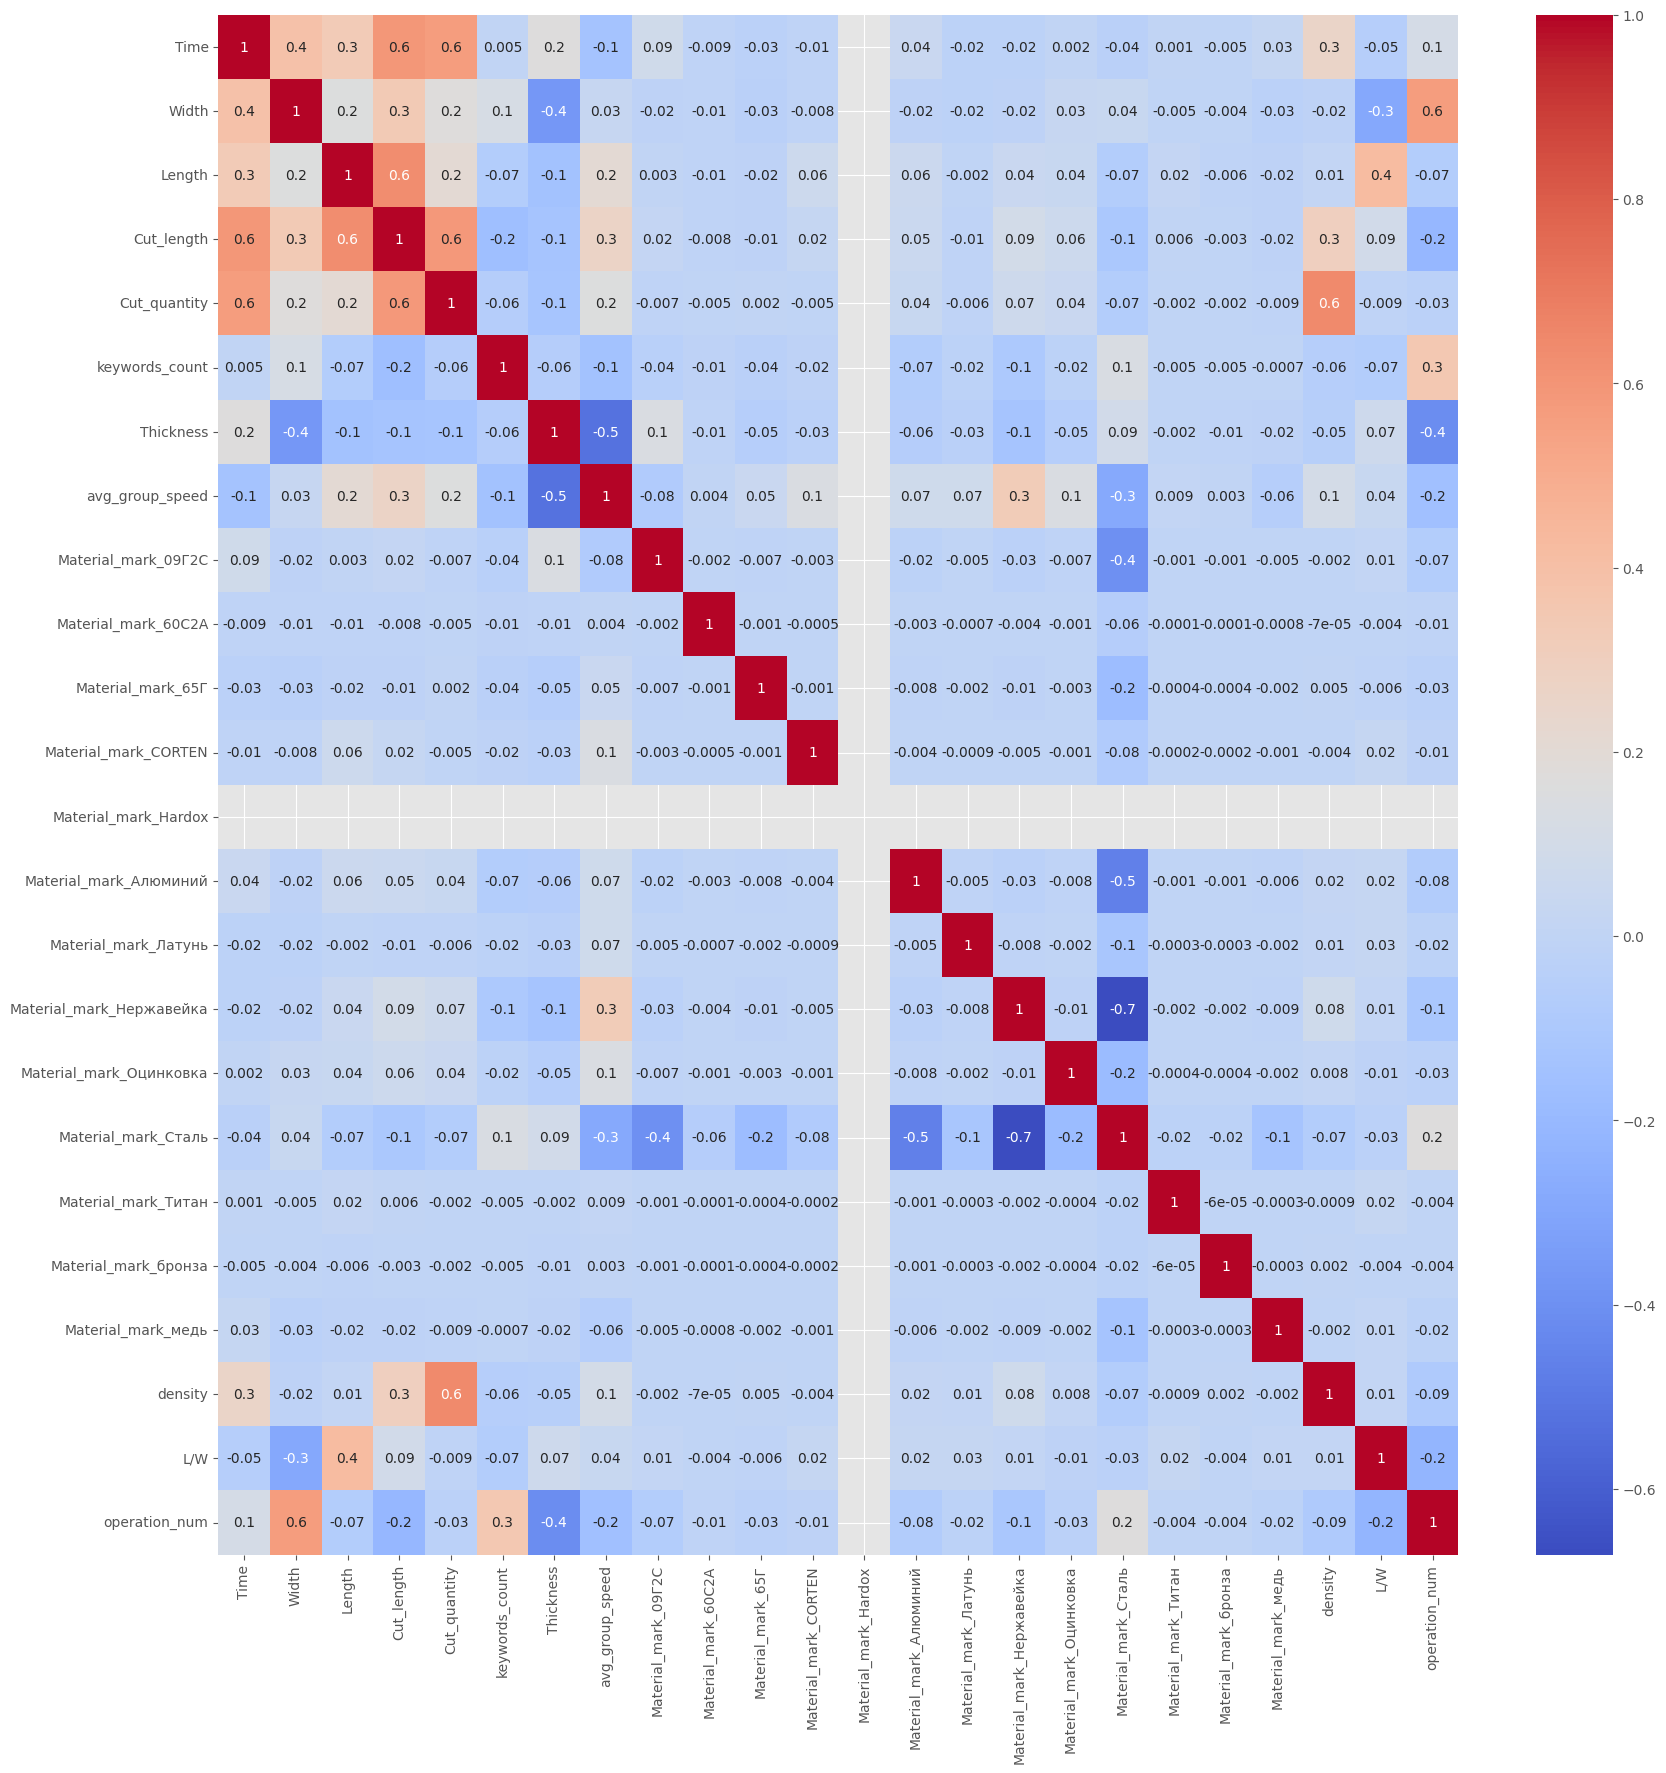

In [17]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), annot = True, ax=ax, fmt='.1g', cmap= 'coolwarm');

Для модели возьмем признаки, с корреляцией более 0.1

### Разделим на выборки

In [18]:
cols=['Cut_length', 
      'Width',
      'Length',
      'avg_group_speed',
      'Material_mark_09Г2С', 'Material_mark_60С2А', 'Material_mark_65Г',
      'Material_mark_CORTEN', 'Material_mark_Hardox', 'Material_mark_Алюминий',
      'Material_mark_Латунь', 'Material_mark_Нержавейка', 'Material_mark_Оцинковка', 
      'Material_mark_Сталь', 'Material_mark_Титан', 'Material_mark_бронза',
      'Cut_quantity', 
      'Thickness',
      'density',
      'operation_num']

X = data[cols]
y = data['Time']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

Создадим датасет для сравнения, добавим baseline

### Baseline

Для baseline просто считаем по формуле

In [20]:
with mlflow.start_run(run_name="Baseline"):
    # Логируем параметры модели
    mlflow.log_param("model_type", "Baseline")
    
    start_time = datetime.now()
    compare = X_test.copy()
    compare['base_y_pred'] = compare['Cut_length'] / compare['avg_group_speed']
    compare = compare.join(y_test)
    end_time = datetime.now()
    
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
       
    # Вычисляем метрики  
    actual_values = compare['Time']
    predicted_values = compare['base_y_pred']
    base_metrics=get_and_print_metrics(predicted_values, actual_values)
    
    
#     # Логируем метрики
    for key, value in base_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.log_param("baselie", "base_y_pred = Cut_length / avg_group_speed")

RMSE: 36.781007935438474
MAPE: 50.47%
SMAPE: 39.48%
R2: 0.26
Процент значений с ошибкой не более 20%: 42.82%
WAPE: 42.06%


In [21]:
compare[['base_y_pred', 'Time']].head(3)

,base_y_pred,Time
372616,17.621,16.000
134729,15.784,24.000
199720,16.558,18.000


На глаз, для первых 3 значений, предсказаниче получилось достаточно точным

### Стандартная линейная регрессия

Обучаем линейную регрессию. Сначала стандартизируем данные

In [24]:
scaler = StandardScaler()
#scaler = QuantileTransformer(random_state=0)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                                   columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val),
                                   columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                                   columns=X_test.columns, index=X_test.index)

In [26]:
with mlflow.start_run(run_name="Linear"):
    mlflow.log_param("model_type", "Linear")
        
    start_time = datetime.now()
    reg = LinearRegression()
    reg.fit(X_train_scaled, y_train)
    y_linear_predict = reg.predict(X_test_scaled)
    compare['y_linear_predict'] = y_linear_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    linear_metrics = get_and_print_metrics(y_linear_predict, y_test)
        
    for key, value in linear_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "linear_regression_model")


            
            


RMSE: 24.704666093461196
MAPE: 69.02%
SMAPE: 49.82%
R2: 0.67
Процент значений с ошибкой не более 20%: 33.89%
WAPE: 36.21%


2024/10/05 16:02:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Сравнение baseline и regression

In [27]:
base_metrics['model_name'] = 'base'
linear_metrics['model_name'] = 'linear'

metrics_dicts = [
    base_metrics,
    linear_metrics,
]

# Создаем DataFrame из списка словарей
compare_metrics = pd.DataFrame(metrics_dicts)

# Переименуем столбец 'model_name' в индекс DataFrame
compare_metrics.set_index('model_name', inplace=True)

compare_metrics

,rmse,mape,smape,R2,percentage_within_20,wape
model_name,,,,,,
base,36.781,0.505,39.483,0.263,42.825,42.055
linear,24.705,0.690,49.824,0.667,33.888,36.208


Видно, что rmse например, сильно лучше у регрессии, но зато процент(точнее 20) лучше у base. 

Нужно определится с метрикой, по которой будем выбирать модель.

Будем смотреть на wape, т.к нам важно не сильно ошибаться относительно каждой конкретной детали (с временем резки 1сек, 10сек, 100сек итд)





Для сравнения, посмотрим на графике, как распределены ошибки (в процентах)

In [28]:
def get_percent_error(pred, fact):
    error = abs(fact - pred)
    return error / fact * 100

In [29]:
compare['base_percent_error'] = compare.apply(lambda x: get_percent_error(x['base_y_pred'], x['Time']), axis=1)
compare['linear_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_linear_predict'], x['Time']), axis=1)

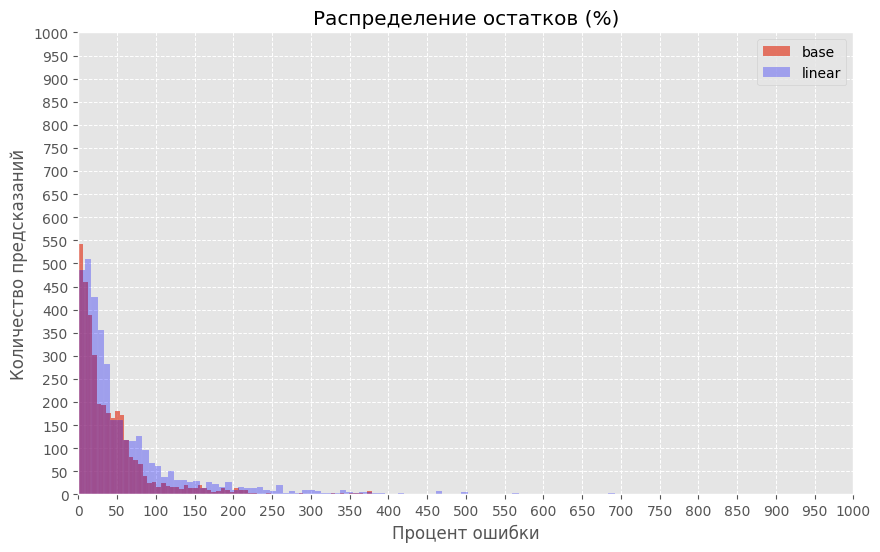

In [30]:
# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error', label='base')
sns.histplot(compare, x='linear_percent_error', color='blue', alpha=0.3, label='linear')

# Ограничиваем значения по оси X до 1000
plt.xlim(0,1000)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 1001, step))
plt.yticks(np.arange(0, 1001, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.legend()

plt.show()

## Улучшение модели (регуляризация)

Попробуем добавить разные методы регуляризации

### lasso

In [31]:
search_lasso = GridSearchCV(estimator=Lasso(),
                           param_grid={'alpha': np.arange(0.01, 10, 0.05)})
search_lasso.fit(X_val_scaled, y_val)
best_lasso = search_lasso.best_estimator_
print("Best alpha:", best_lasso.alpha)

Best alpha: 0.56


In [32]:
with mlflow.start_run(run_name="Lasso"):
    mlflow.log_param("model_type", "Lasso")
        
    start_time = datetime.now()
    lasso_reg = Lasso(alpha=best_lasso.alpha)
    lasso_reg.fit(X_train_scaled, y_train)
    y_lasso_predict = lasso_reg.predict(X_test_scaled)
    compare['y_lasso_predict'] = y_lasso_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    lasso_metrics = get_and_print_metrics(y_lasso_predict, y_test)     
    
    for key, value in lasso_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "lasso_regression_model")



RMSE: 25.09637891369895
MAPE: 63.63%
SMAPE: 45.54%
R2: 0.66
Процент значений с ошибкой не более 20%: 36.54%
WAPE: 35.75%


2024/10/05 16:11:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### ridge

In [33]:
search_ridge = GridSearchCV(estimator=Ridge(),
                           param_grid={'alpha': np.arange(0.01, 10, 0.05)})
search_ridge.fit(X_val_scaled, y_val)
best_ridge = search_ridge.best_estimator_
print("Best alpha:", best_ridge.alpha)

Best alpha: 9.96


In [34]:
with mlflow.start_run(run_name="Ridge"):
    mlflow.log_param("model_type", "Ridge")
        
    start_time = datetime.now()
    ridge_reg = Ridge(alpha=best_ridge.alpha)
    ridge_reg.fit(X_train_scaled, y_train)
    y_ridge_predict = ridge_reg.predict(X_test_scaled)
    compare['y_ridge_predict'] = y_ridge_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    ridge_metrics = get_and_print_metrics(y_ridge_predict, y_test)  
    
    for key, value in ridge_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "ridge_regression_model")



RMSE: 24.70253010095751
MAPE: 68.87%
SMAPE: 49.68%
R2: 0.67
Процент значений с ошибкой не более 20%: 33.89%
WAPE: 36.18%


2024/10/05 16:11:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### ElasticNet

In [35]:
# Определение пространства поиска гиперпараметров
param_grid = {
    'alpha': np.logspace(-3, 3, 10),
    'l1_ratio': np.linspace(0.01, 1, 100)
}

# Инициализация RandomizedSearchCV
random_search_elnet = RandomizedSearchCV(
    estimator=ElasticNet(),
    param_distributions=param_grid,
    cv=5,  # Количество кросс-валидаций
    n_iter=50,  # Количество итераций для случайного подбора
    random_state=42,  # Для воспроизводимости результатов
)

# Подбор гиперпараметров
random_search_elnet.fit(X_val_scaled,y_val)

# Получение лучшей модели
best_random_elnet = random_search_elnet.best_params_

l1_ratio_best = best_random_elnet['l1_ratio']
alpha_best = best_random_elnet['alpha']

print(f"Best l1_ratio: {l1_ratio_best}")
print(f"Best alpha: {alpha_best}")

Best l1_ratio: 1.0
Best alpha: 0.46415888336127775


In [36]:
with mlflow.start_run(run_name="ElasticNet"):
    mlflow.log_param("model_type", "ElasticNet")
        
    start_time = datetime.now()
    elasticnet_reg = ElasticNet(alpha=0.001, l1_ratio=0.97)
    elasticnet_reg.fit(X, y)
    y_elasticnet_predict = elasticnet_reg.predict(X_test[cols])
    compare['y_elasticnet_predict'] = y_elasticnet_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    elasticnet_metrics = get_and_print_metrics(y_elasticnet_predict, y_test)  
    
    for key, value in elasticnet_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "ElasticNet_regression_model")




RMSE: 24.550807090961673
MAPE: 67.81%
SMAPE: 49.14%
R2: 0.67
Процент значений с ошибкой не более 20%: 34.20%
WAPE: 35.70%


2024/10/05 16:12:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Сравнение результатов

In [37]:
lasso_metrics['model_name'] = 'lasso'
elasticnet_metrics['model_name'] = 'elasticNet'
ridge_metrics['model_name'] = 'ridge'

In [38]:
metrics_dicts.extend(
    [lasso_metrics,
    elasticnet_metrics,
    ridge_metrics]
)

In [39]:
# Создаем DataFrame из списка словарей
compare_metrics = pd.DataFrame(metrics_dicts)

# Переименуем столбец 'model_name' в индекс DataFrame
compare_metrics.set_index('model_name', inplace=True)

compare_metrics

,rmse,mape,smape,R2,percentage_within_20,wape
model_name,,,,,,
base,36.781,0.505,39.483,0.263,42.825,42.055
linear,24.705,0.690,49.824,0.667,33.888,36.208
lasso,25.096,0.636,45.541,0.657,36.538,35.750
elasticNet,24.551,0.678,49.140,0.671,34.198,35.703
ridge,24.703,0.689,49.677,0.667,33.888,36.179


Базовая модель дает 43% предсказаний, с ошибкой меньше 20%. Что лучше любой регрессии. 
Проигрывает регрессии только по rmse

lasso - лучшая из регрессий, но не имеет явного преимущества перед baseline

Следующий шаг - попробовать полиномиальную регрессию

## Улучшение модели (полином)

Подберем оптимальную степень полинома, ограничемся выбором из 1,2,3

In [41]:
from sklearn.pipeline import Pipeline

# pipeline:сначала применяюются полиномиальные признаки и затем линейная регрессия
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('linear_regression', LinearRegression())
])

# Определение сетки гиперпараметров
param_grid = {
    'poly_features__degree': range(1, 4) 
}

# Настройка GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучение модели на подвыборке данных
grid_search.fit(X_val_scaled, y_val)

# Лучшая степень полинома
best_degree = grid_search.best_params_['poly_features__degree']
print(f'Оптимальная степень полинома: {best_degree}')


Оптимальная степень полинома: 2


Используем полином 2 степени

In [47]:
poly_feat = PolynomialFeatures(degree=best_degree)
X_poly = poly_feat.fit_transform(pd.DataFrame(X_train))

with mlflow.start_run(run_name="Poly"):
    mlflow.log_param("model_type", "Poly")
        
    start_time = datetime.now()
    reg_poly = LinearRegression()
    reg_poly.fit(X_poly, y_train)    

    y_poly_predict = reg_poly.predict(poly_feat.transform(X_test))
    compare['y_poly_predict'] = y_poly_predict
    end_time = datetime.now()
        
    mlflow.log_metric("training_time", (end_time - start_time).total_seconds())
        
    y_poly_metrics = get_and_print_metrics(y_poly_predict, y_test)
    
    for key, value in y_poly_metrics.items():
        mlflow.log_metric(key, value)
    
    # Сохраняем модель
    mlflow.sklearn.log_model(reg, "Polynomial_regression_model")






RMSE: 22.62704951511836
MAPE: 26.26%
SMAPE: 21.59%
R2: 0.72
Процент значений с ошибкой не более 20%: 63.97%
WAPE: 20.68%


2024/10/05 16:22:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [48]:
new_row = pd.Series(y_poly_metrics.values(), 
                    index=['rmse', 'mape', 'smape', 'R^2', 'percentage_within_20', 'wape'])

# Добавляем новую строку в DataFrame
compare_metrics.loc['poly'] = new_row

In [49]:
compare_metrics 

,rmse,mape,smape,R2,percentage_within_20,wape
model_name,,,,,,
base,36.781,0.505,39.483,0.263,42.825,42.055
linear,24.705,0.690,49.824,0.667,33.888,36.208
lasso,25.096,0.636,45.541,0.657,36.538,35.750
elasticNet,24.551,0.678,49.140,0.671,34.198,35.703
ridge,24.703,0.689,49.677,0.667,33.888,36.179
poly,22.627,0.263,21.590,NaN,63.970,20.684


# Визуализация результатов

Также, как выше, посмотрим распределение остатков base с poly

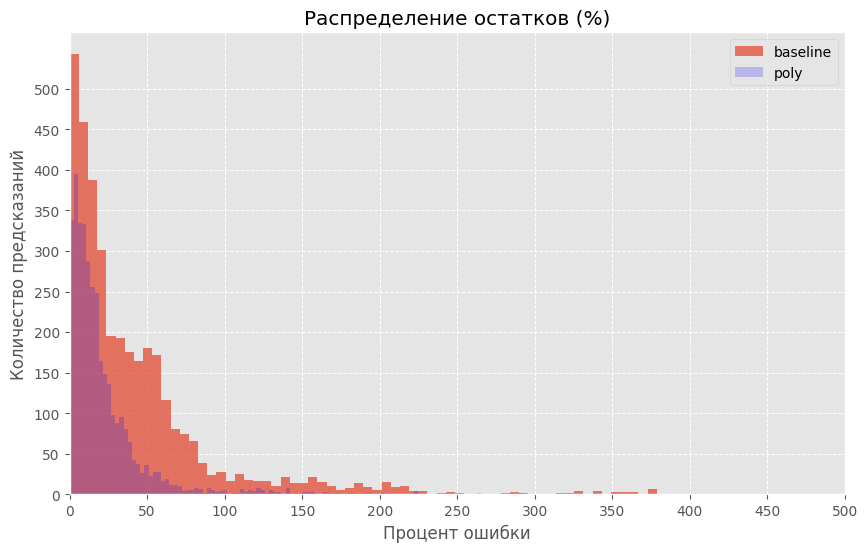

In [51]:
compare['poly_percent_error'] = compare.apply(lambda x: get_percent_error(x['y_poly_predict'], x['Time']), axis=1)

# Построение гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(compare, x='base_percent_error', label ='baseline')
sns.histplot(compare, x='poly_percent_error', color='blue', alpha=0.2, label='poly')

# Ограничиваем значения по оси X до 1000
plt.xlim(0,500)

# Задаем шаг для меток оси X (например, шаг 100)
step = 50
plt.xticks(np.arange(0, 501, step))
plt.yticks(np.arange(0, 501, step))

# Включаем сетку и задаем тот же шаг
plt.grid(True, axis='x', which='both', linestyle='--', linewidth=0.7)
plt.grid(True, axis='y', which='both', linestyle='--', linewidth=0.7)


# Добавим подписи и заголовок (если нужно)
plt.xlabel('Процент ошибки')
plt.ylabel('Количество предсказаний')
plt.title('Распределение остатков (%)')

plt.legend()

plt.show()

Почти все предсказания poly скучены до ошибки в 50%

Посмотрим на линию предсказания для 2х главных признаков (корреляция > 0.5) 
- длина реза
- количество врезок

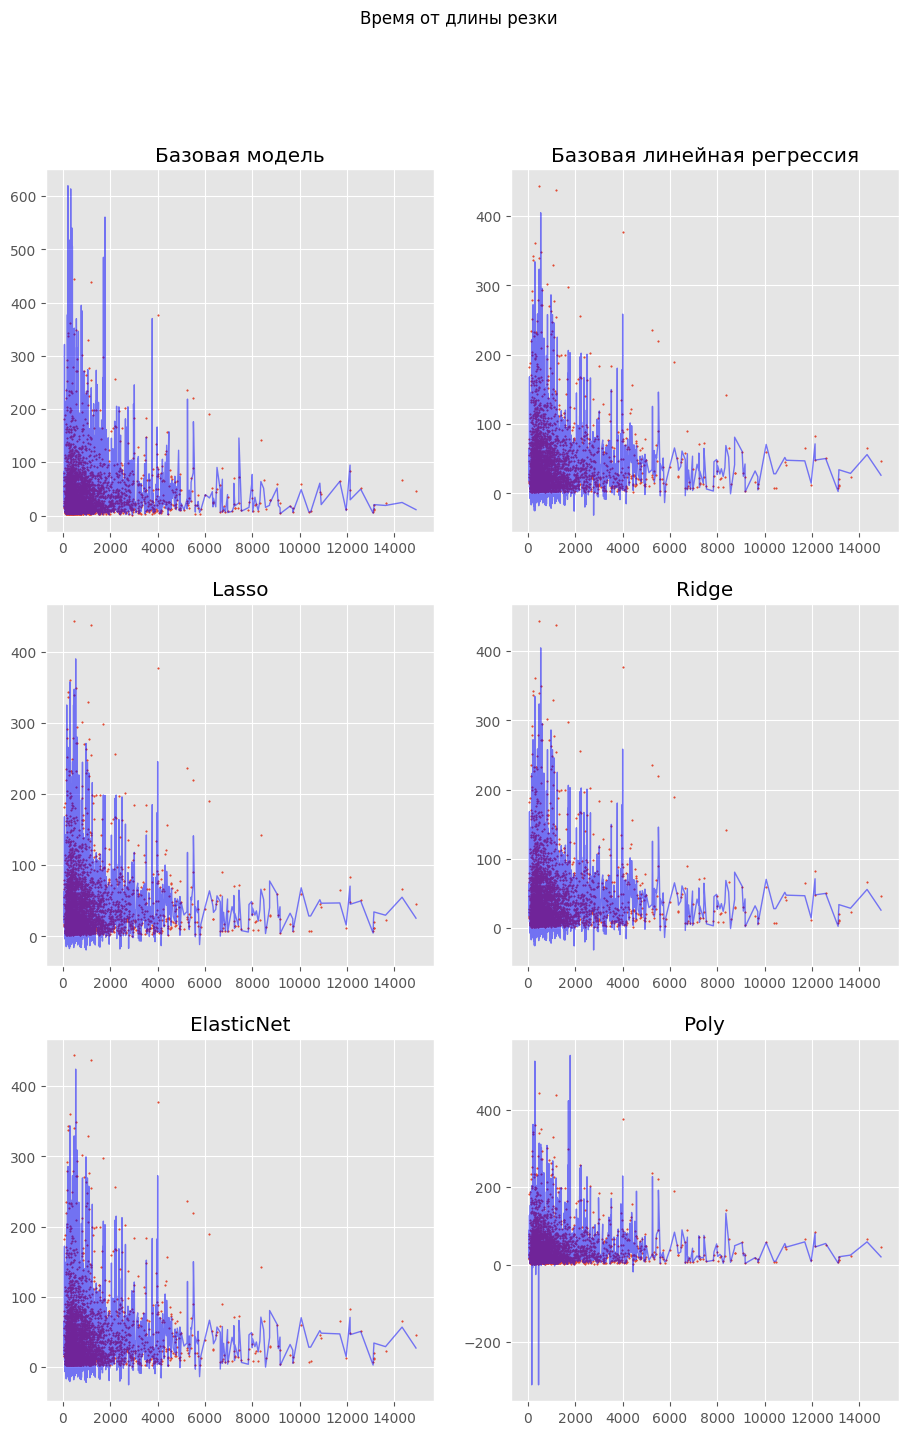

In [52]:
X = X_test['Cut_length'].sort_values()


fig, ax = plt.subplots(3, 2, figsize=(11,16))
fig.suptitle('Время от длины резки')


ax[0,0].scatter(X, y_test, s=1)
ax[0,1].scatter(X, y_test, s=1)
ax[1,0].scatter(X, y_test, s=1)
ax[1,1].scatter(X, y_test, s=1)
ax[2,0].scatter(X, y_test, s=1)
ax[2,1].scatter(X, y_test, s=1)


ax[0,0].set_title('Базовая модель')
ax[0,1].set_title('Базовая линейная регрессия')
ax[1,0].set_title('Lasso')
ax[1,1].set_title('Ridge')
ax[2,0].set_title('ElasticNet')
ax[2,1].set_title('Poly')


ax[0,0].plot(X, compare['base_y_pred'], lw=1, color = 'blue', alpha = 0.5)
ax[0,1].plot(X, compare['y_linear_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,0].plot(X, compare['y_lasso_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,1].plot(X, compare['y_ridge_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,0].plot(X, compare['y_elasticnet_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,1].plot(X, compare['y_poly_predict'], lw=1, color = 'blue', alpha = 0.5);

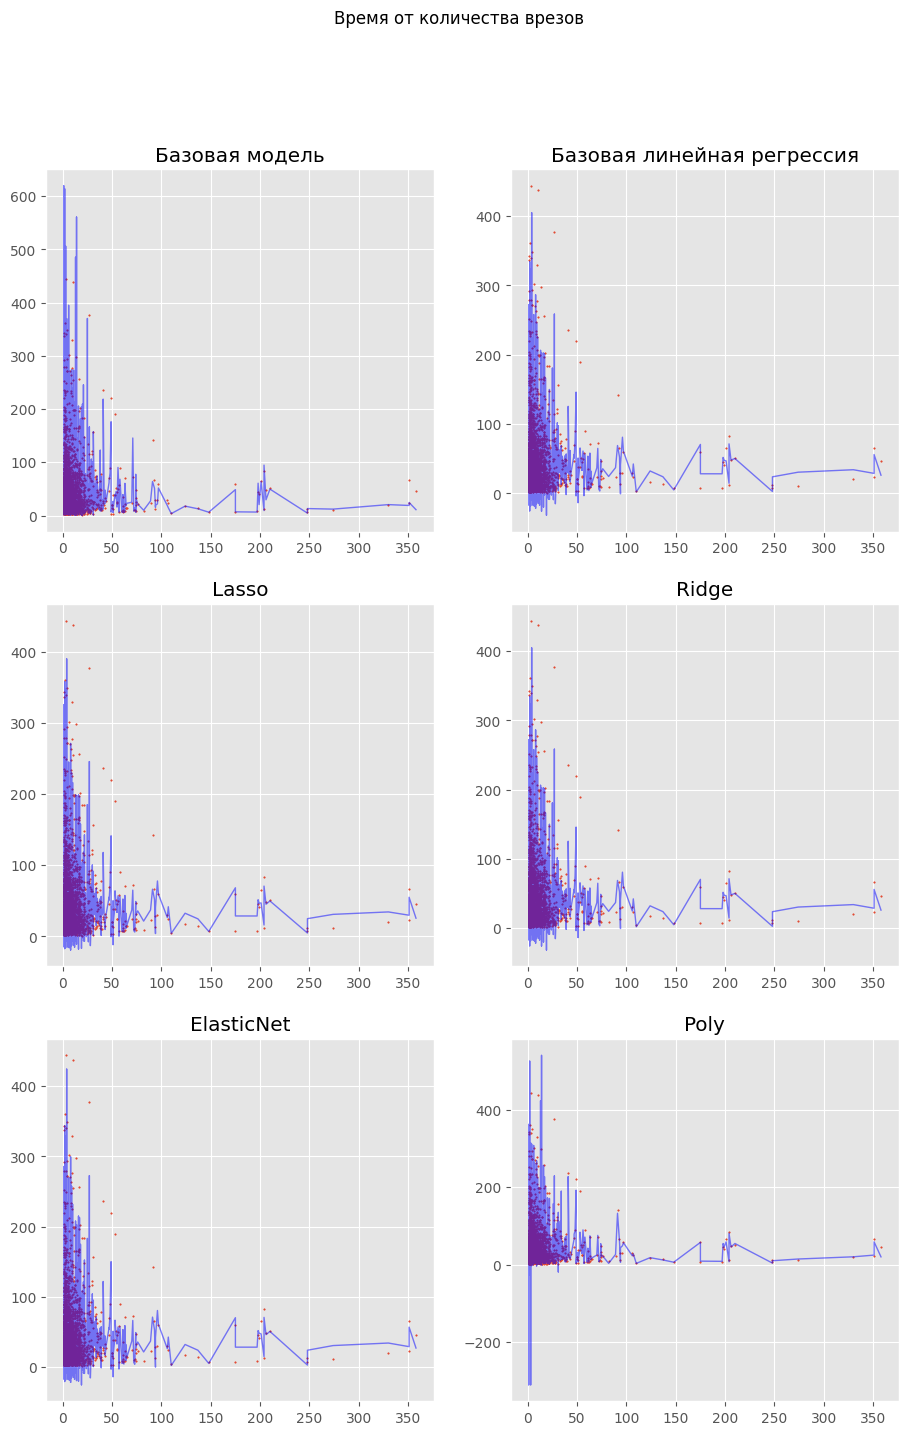

In [53]:
X = X_test['Cut_quantity'].sort_values()


fig, ax = plt.subplots(3, 2, figsize=(11,16))
fig.suptitle('Время от количества врезов')


ax[0,0].scatter(X, y_test, s=1)
ax[0,1].scatter(X, y_test, s=1)
ax[1,0].scatter(X, y_test, s=1)
ax[1,1].scatter(X, y_test, s=1)
ax[2,0].scatter(X, y_test, s=1)
ax[2,1].scatter(X, y_test, s=1)


ax[0,0].set_title('Базовая модель')
ax[0,1].set_title('Базовая линейная регрессия')
ax[1,0].set_title('Lasso')
ax[1,1].set_title('Ridge')
ax[2,0].set_title('ElasticNet')
ax[2,1].set_title('Poly')


ax[0,0].plot(X, compare['base_y_pred'], lw=1, color = 'blue', alpha = 0.5)
ax[0,1].plot(X, compare['y_linear_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,0].plot(X, compare['y_lasso_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[1,1].plot(X, compare['y_ridge_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,0].plot(X, compare['y_elasticnet_predict'], lw=1, color = 'blue', alpha = 0.5)
ax[2,1].plot(X, compare['y_poly_predict'], lw=1, color = 'blue', alpha = 0.5);

Полиноминальная регрессия точнее приближена к точкам

Однако, есть предсказания меньше 0

In [54]:
len(compare[compare['y_poly_predict']<0])

14

In [55]:
compare[compare['y_poly_predict']<0][['Time', 'y_poly_predict']][:10]

,Time,y_poly_predict
411699,162.000,-309.911
322826,4.000,-1.585
305033,4.000,-8.079
309980,8.000,-0.888
2699,3.000,-0.317
294251,2.000,-1.101
459095,112.000,-25.492
121392,162.000,-309.911
338421,3.000,-1.586
216389,4.000,-2.266


Таких предсказаний всего 14, и судя по значениям, для многих, можно использовать просто модуль.

Считаем, что полиноминальная модель справилась хорошо

# Итог

С линейной регрессией не получилось добиться значительного улучшения относительно базовой модели.

Незначительное улучшение дает lasso регуляризация. 

Значительное улучшение в качестве (приемлимое для ухода от базовой модели) получено с использованием полиномиальных признаков 2 степени. 

Для дальнейшего улучшения модели можно попробовать изменить предобработку данных.

Следующий шаг - использование mlflow для автоматизации процесса предобработки (отдельный блокнот)